## Support Vector Machine

                    - From scratch 

In [1]:
# svm.py
import numpy as np  # for handling multi-dimensional array operation
import pandas as pd  # for reading data from csv 
from sklearn.preprocessing import MinMaxScaler  # for normalization
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle


In [2]:
#Breast Cancer Dataset

data = pd.read_csv('./data.csv')

data.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
print(data.shape)

(569, 33)


In [4]:
def init():
    print("reading dataset...")
    # read data in pandas (pd) data frame
    data = pd.read_csv('./data.csv')

    # drop last column (extra column added by pd)
    # and unnecessary first column (id)
    data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

    print("applying feature engineering...")
    # convert categorical labels to numbers
    
    diag_map = {'M': 1.0, 'B': -1.0}
    data['diagnosis'] = data['diagnosis'].map(diag_map)

    # put features & outputs in different data frames
    Y = data.loc[:, 'diagnosis']
    X = data.iloc[:, 1:]


    # normalize data for better convergence and to prevent overflow
    X_normalized = MinMaxScaler().fit_transform(X.values)
    X = pd.DataFrame(X_normalized)

    # insert 1 in every row for intercept b
    X.insert(loc=len(X.columns), column='intercept', value=1)
    return X,Y

Intercept is added to each sample so that we can perform matrix operations directly
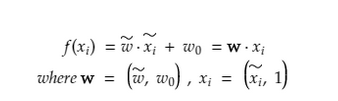

In [5]:
def train(X_train,X_test, y_train, y_test):  
    # train the model
    print("training started...")
    W = sgd(X_train.to_numpy(), y_train.to_numpy())
    print("training finished.")
    print("weights are: {}".format(W))
    
    # testing the model
    print("testing the model...")
    y_train_predicted = predict(X_train,W)
    y_test_predicted = predict(X_test, W)
    
    print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
    print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    print("precision on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    
    return W

In [6]:
def predict(X,W):  
    y_predicted = np.array([])
    
    for i in range(X.shape[0]):
        yp = np.sign(np.dot(X.to_numpy()[i], W))
        y_predicted = np.append(y_predicted, yp)
    return y_predicted
    

#### COST FUNCTION
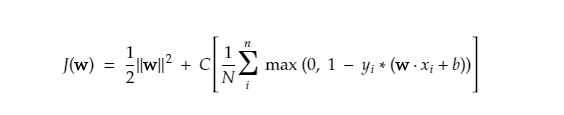

In [7]:
def compute_cost(W, X, Y):
    
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost

Gradient of the cost function
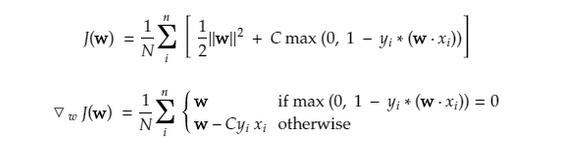

In [8]:
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw

In [9]:
def sgd(features, outputs):
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        
        X, Y = shuffle(features, outputs)
        
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            if abs(prev_cost - cost) < cost_threshold * prev_cost:
                return weights
            
            prev_cost = cost
            nth += 1
    return weights

In [10]:
regularization_strength = 10000 # regularization strength
learning_rate = 0.000001

X,Y= init()
X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)
W=train(X_train, X_test, y_train, y_test)

reading dataset...
applying feature engineering...
training started...
Epoch is: 1 and Cost is: 5297.058399902605
Epoch is: 2 and Cost is: 3354.8584989450187
Epoch is: 4 and Cost is: 2407.0806300219615
Epoch is: 8 and Cost is: 1886.1422553139369
Epoch is: 16 and Cost is: 1529.9171812083362
Epoch is: 32 and Cost is: 1210.477827613412
Epoch is: 64 and Cost is: 957.5159985827719
Epoch is: 128 and Cost is: 804.4045531750355
Epoch is: 256 and Cost is: 703.3860328881187
Epoch is: 512 and Cost is: 647.3890452316782
Epoch is: 1024 and Cost is: 622.2057121021846
Epoch is: 2048 and Cost is: 617.9178278801303
training finished.
weights are: [ 1.05444162  1.07887176  0.9189515   2.04343338 -1.14807089 -2.5888178
  3.32881088  5.86988105 -0.52222032 -0.43724556  5.00453511 -1.54467363
  3.06531282  3.22837818  1.64105661 -2.44283462 -1.20466088  0.24257883
 -1.64967713 -1.39179962  2.87212361  4.91149329  1.59339868  3.0763945
  2.40117052 -0.84443592  2.2784326   0.88963462  4.54279212  1.79175348

### Visualization

In [28]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.n_components=2
pca=pca.fit(X)

In [29]:
W_pos=W.copy()
W_pos[-1]=W_pos[-1]-1


W_neg = W.copy()
W_neg[-1]= W_neg[-1]+1

In [30]:
W_pos_rowVec= W_pos.reshape(-1, 1).T
W_neg_rowVec=W_neg.reshape(-1,1).T

In [31]:
W_rowVec= W.reshape(-1, 1).T

X_W= np.vstack((X, W_rowVec))
X_W = np.vstack((X_W, W_pos_rowVec))
X_W= np.vstack((X_W, W_neg_rowVec))

In [32]:
X_W.shape

(572, 31)

In [33]:
X.shape, X_W.shape, W_rowVec.shape

((569, 31), (572, 31), (1, 31))

In [34]:
data=X_W[-3:-1, :]
data

array([[  1.05444162,   1.07887176,   0.9189515 ,   2.04343338,
         -1.14807089,  -2.5888178 ,   3.32881088,   5.86988105,
         -0.52222032,  -0.43724556,   5.00453511,  -1.54467363,
          3.06531282,   3.22837818,   1.64105661,  -2.44283462,
         -1.20466088,   0.24257883,  -1.64967713,  -1.39179962,
          2.87212361,   4.91149329,   1.59339868,   3.0763945 ,
          2.40117052,  -0.84443592,   2.2784326 ,   0.88963462,
          4.54279212,   1.79175348,  -9.2593074 ],
       [  1.05444162,   1.07887176,   0.9189515 ,   2.04343338,
         -1.14807089,  -2.5888178 ,   3.32881088,   5.86988105,
         -0.52222032,  -0.43724556,   5.00453511,  -1.54467363,
          3.06531282,   3.22837818,   1.64105661,  -2.44283462,
         -1.20466088,   0.24257883,  -1.64967713,  -1.39179962,
          2.87212361,   4.91149329,   1.59339868,   3.0763945 ,
          2.40117052,  -0.84443592,   2.2784326 ,   0.88963462,
          4.54279212,   1.79175348, -10.2593074 ]])

In [35]:
pca_X_W= pca.transform(X_W)

In [36]:
pca_X_W.shape

(572, 2)

In [37]:
X_pca_data= pca_X_W[:-3, :]
X_pca_data.shape

(569, 2)

In [38]:
W_pca_data = pca_X_W[-3,:]
W_pca_pos_data =pca_X_W[-2,:]
W_pca_neg_data = pca_X_W[-1,:]

W_pca_data, W_pca_pos_data, W_pca_neg_data

(array([ 6.71940884, -3.77133346]),
 array([ 6.71940884, -3.77133346]),
 array([ 6.71940884, -3.77133346]))

In [39]:
import seaborn as sn
import matplotlib.pyplot as plt 

In [40]:
def abline(W_data):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array([1,-0.5])
    y_vals = -W_data[0] * x_vals /W_data[1]
    plt.plot(x_vals, y_vals)

In [50]:
import math 

# Function to find distance 
def shortest_distance(W, x):    
    d = abs((np.dot(W,x)) / (math.sqrt(np.dot(W,W))) )
    return d

def support_vectors(W, X, X_pca_data):
     for i in range(X.shape[0]):
        d= shortest_distance(W,X.to_numpy()[i])
        if (d<0.05): 
            plt.plot(X_pca_data[i][0],X_pca_data[i][1],'ro')
        

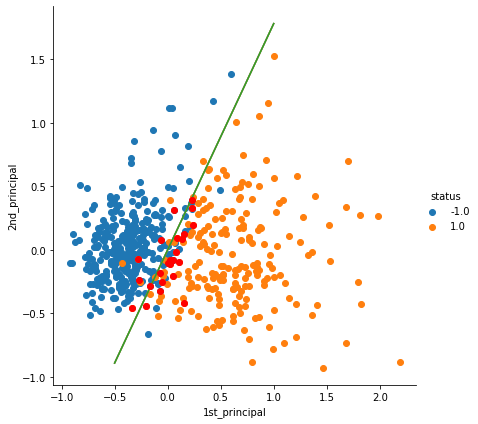

In [51]:
pca_data = np.vstack((X_pca_data.T, Y)).T
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "status"))
sn.FacetGrid(pca_df, hue="status", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
abline(W_pca_data)
abline(W_pca_pos_data)
abline(W_pca_neg_data)

support_vectors(W, X, X_pca_data)

plt.show()


Here, the positive hyperplane, negative hyperplane and maximum margin hyperplane are projected to same line in 2d, and the points in red are support vectors in 31d projected into 2d. 